## Clean version of post_pro_landau_rel

We use it and then move the results to Notes_log.

In [1]:
#using DifferentialEquations
using Plots
using Statistics
using FFTW
FFTW.set_provider!("mkl")
#import Pkg; Pkg.add("FileIO")
using FileIO
using JLD2
using Base.Threads
using Distributions
using LaTeXStrings
using Printf
using LsqFit

In [2]:
include("aux_functions.jl")

temperature_fit (generic function with 1 method)

In [3]:
outputs = false # detailed output (no longer used)
average_outputs = true
full_outputs = false
animation = false # to run animations
phase_space_show = false #show phase space diagrams
phase_space_show = true
remote_server = false # if run in remote as a script avoid all plots 
save_plots = true # put true is you want so save your plots.
plots = true

true

We first introduce the name of the file with the data and retrieve the metadata.

In [4]:
#file_name = "Results/norel_norm_undamped_rel_t400_L4_N85_n2_J80_M16001_o5_Th3_alp2_ave.jld2"
file_name = "Results/norel_norm_undamped_rel_t400_L4_N86_n2_J80_M16001_o5_Th3_alp2_ave.jld2"
#file_name = "Results/norel_norm_undamped_rel_t400_L39.738_N86_n2_J3522_M16001_o5_Th3_alp2_ave.jld2"



"Results/norel_norm_undamped_rel_t400_L4_N86_n2_J80_M16001_o5_Th3_alp2_ave.jld2"

In [7]:
data, run_name, par_grid, par_evolv, par_f, n0, x, t_series = retrieve_meta_data(file_name)
@show run_name
@show (N, L, J, dx, order) = par_grid
@show (t_i, t_f, M, M_g, dt) = par_evolv
@show (θ, nm, k) = par_f

dT = dt*(M-1)/(M_g-1)


freqs_space = L*rfftfreq(J, 1/dx)

M_last = 888  # number of last data point saved. Otherwise use M_g
#freqs_time = fftshift(rfftfreq(M_last, 1/dT))
freqs_time = rfftfreq(M_last, 1/dT)*2*π;

run_name = "norel_norm_undamped_rel_t400_L4_N86_n2_J80_M16001_o5_Th3_alp2"
(N, L, J, dx, order) = par_grid = (8000000, 4, 80, 0.05, 5)
(t_i, t_f, M, M_g, dt) = par_evolv = (0.0, 400.0, 16001, 8001, 0.025)
(θ, nm, k) = par_f = (0.001, 2, 1.5707963267948966)


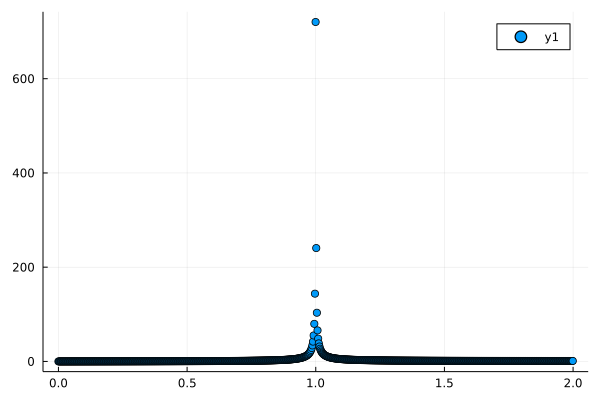

In [6]:
if true
f_test(t) = sin(2*π*5*t)
F_test = rfft(f_test.(t_series))
freqs_time_test = (rfftfreq(M_g, 1/dT));
Plots.scatter(freqs_time_test, (abs.(F_test)))
end

We can have data written out in full o in averaged format: In each case we use different functions. Data written in full has a `"full.jld2"` at the end, otherwise a `"ave.jld2"` is used.

For the full case we use:

```
v = retrieve_data(data, par_grid par_evolv);
```
```
Energy_K, Energy_E, EField_T, p_T, Q_T, S_T, T = get_averages_threads(v,par_grid,par_evolv, par_f);
```

For the averaged case we use:

```
M_last = 1601 # number of iterations already completed. 

n_t, S_t, Efield_t, averages = retrieve_average_data(data, par_grid, par_evolv;M_last=M_last);

Energy_E,  Energy_K, EField_T, p_T, Q_T, S_T, T = averages;
```



In [8]:

n_t, S_t, Efield_t, averages = retrieve_average_data(data, par_grid, par_evolv;M_last=M_last);

Energy_E,  Energy_K, EField_T, p_T, Q_T, S_T, T = averages;


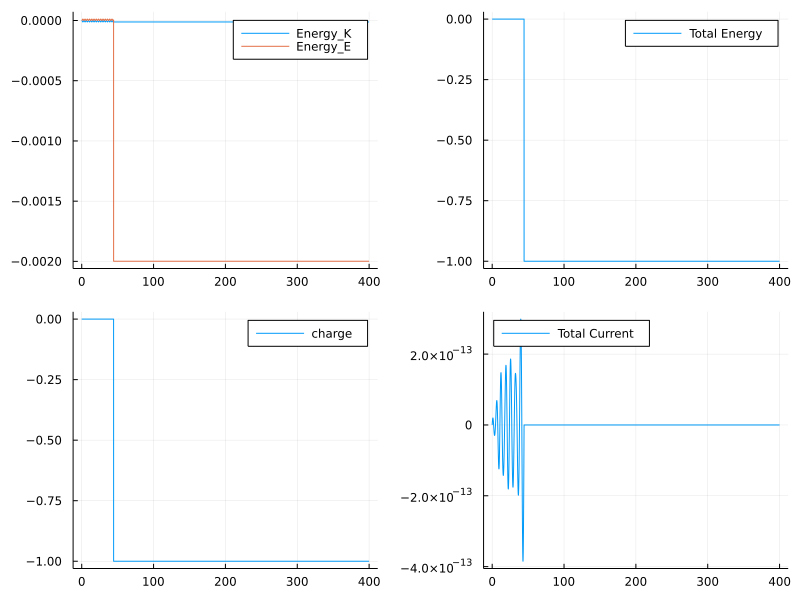

In [9]:

plot_averages(averages, t_series, N, run_name, save_plots)

#### Energy fit 

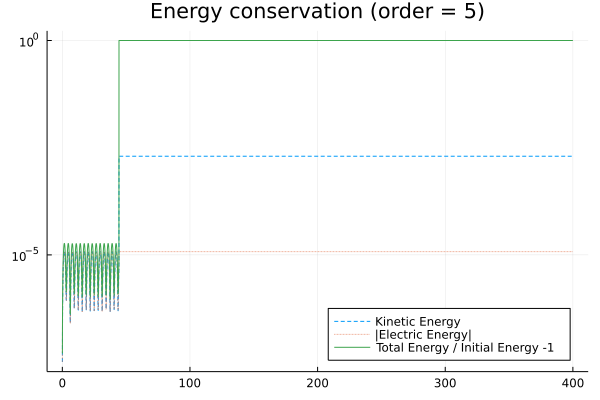

In [10]:
plot_energies(Energy_K, Energy_E, t_series, run_name, save_plots)

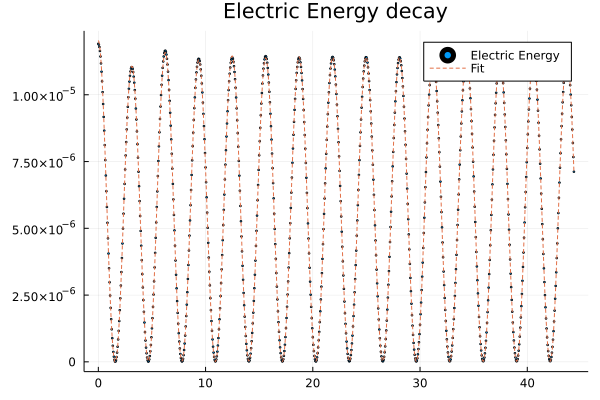

In [11]:
@. model_e1(x,p) =  p[1] + p[2]*cos(p[3]*x + p[4])*exp(-p[5]*x) + p[6]*cos(p[7]*x + p[8])*exp(-p[9]*x)
@. model_e2(x,p) = p[1] + p[2]*(cos(p[3]*x + p[4])^2-p[6])*exp(-p[5]*x)
@. model_e3(x,p) = p[1] + (p[2]*cos(p[3]*x + p[4])*exp(-p[5]*x) + p[6]*cos(p[7]*x + p[8])*exp(-p[9]*x))^2

pe1 = [0.00001; 0.0001; 2; 0; 0.002; 0.00001; 2; 0; 0.0]
#pe2 = [0.0001; -0.0001; 1; 0; 0.002; 0.5]

#pe = [0.001; 0.001; 2.03; 2; 0.002; 0.001; 3.0; 0.0; 0.0]
#pe = [0.01; -0.01; 1; 0; 0.002; 0.0]
pe_3 = [0.00001; 0.001; 1.03; 2; 0.000; 0.001; 1.002; 0.0; 0.000]
#pe_3 = fit_e.param
fit_e, plt = energy_fit(t_series, Energy_E, model_e1, pe1, 1, M_last, run_name, save_plots, yscale=:identity)
plt 

In [12]:
fit_e.param

9-element Vector{Float64}:
  5.71345787631049e-6
  5.6927050403978355e-6
  2.013063567191867
  0.00629541501250301
 -1.4754647604709065e-5
 -6.277397019616983e-7
  0.9848884282069859
  3.237059140877542
  0.20302308388122342

#### Temperature Fit

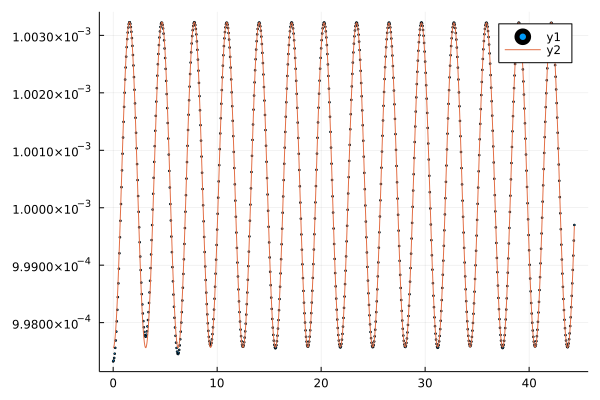

In [13]:
N_i = 1
N_f = M_last
p_tl001 = [0.001; 0.001; 2.02; 0; 0.0; 0.; 2.0; 0; 0]
fit_T_1, plt = temperature_fit(t_series, T, p_tl001, N_i, N_f, run_name, save_plots)
plt

In [14]:
#model_tl001(x,p) = p[1] + p[2]*cos(p[3]*x + p[4])*exp(-p[5]*x) + p[6]*cos(p[7]*x + p[8])*exp(-p[9]*x)
fit_T_1.param

9-element Vector{Float64}:
  0.001000397576039075
  0.00022325044032498728
  2.0201182269926665
  0.063030915178331
 -0.005181990170684039
 -0.00022608026476117927
  2.020058269105414
  0.06202978751336672
 -0.005108584079880118

In [16]:
ΔT = T .- sum(T)/length(T)
T_F = rfft(ΔT)
Plots.scatter(freqs_time,abs.((T_F)), title = " Temperature Spectrum", label="abs.(T_F)",legend=:topleft
, xticks=1.9:0.05:2.3, xlim=(1.9,2.3)
)
#=
Plots.scatter(abs.((T_F)), title = "Spectrum", label="abs.(T_F)",legend=:topleft
    , xticks=100:1:200, xlim=(120,140)
    )
    =#

    if save_plots
        png("Images/" * run_name * "_temperature_spectrum.png")
    end

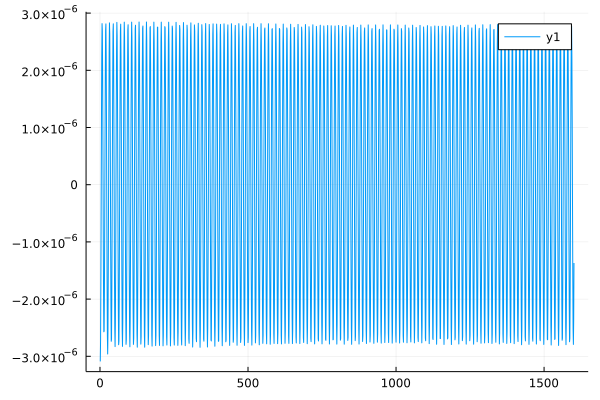

In [17]:
plot(ΔT)

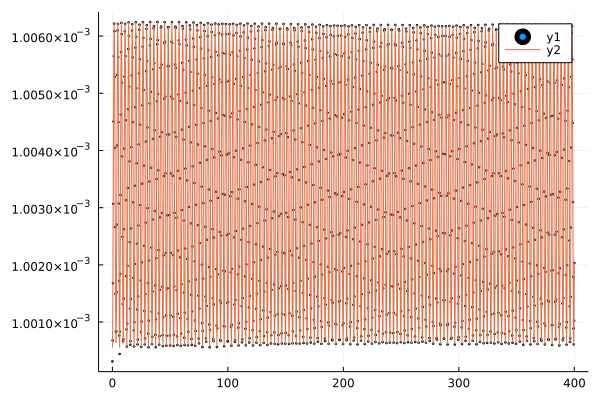

In [18]:
N_i = 1
N_f = M_last
p_tl001 = [0.00; 0.001; 2.02; 0; 0.0; 0.; 2.0; 0; 0]
fit_ΔT_1, plt = temperature_fit(t_series, T, p_tl001, N_i, N_f, run_name, save_plots)
plt

In [19]:
fit_ΔT_1.param

9-element Vector{Float64}:
  0.0010034058638795666
 -4.1223114764688e-8
  2.0063011709906187
 -1.3552174688812222
 -0.0017476671020911763
 -2.84295167345835e-6
  2.0131663714058456
  0.01628600603897624
 -1.3033816486003403e-5

#### Density study

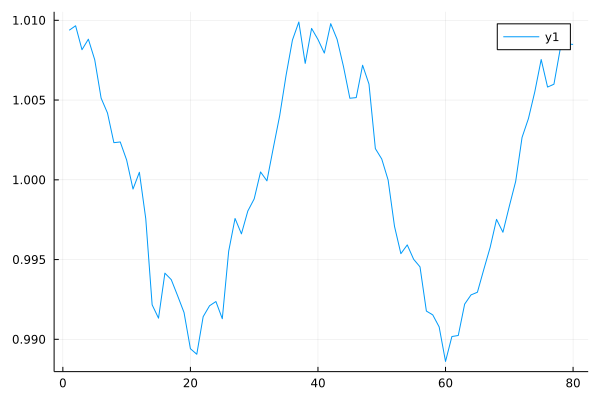

In [20]:
plot(n_t[:,M_last])

In [21]:
n_F = rfft(n_t[:,M_last].-1); # we take out the background
#n_F = rfft(n_t[:,1].-1); # we take out the background

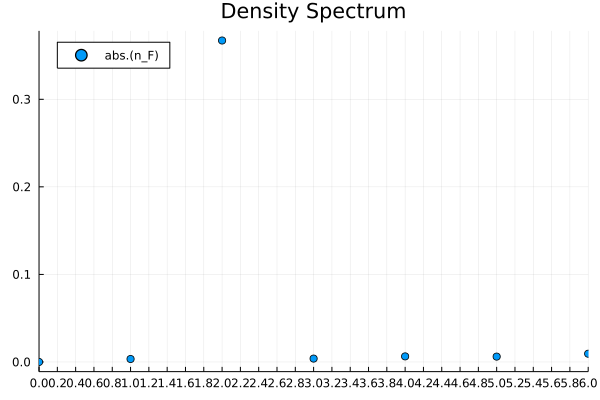

In [24]:
Plots.scatter(freqs_space,abs.((n_F)), title = "Density Spectrum", label="abs.(n_F)",legend=:topleft
    , xticks=0:0.2:6
    , xlim=(0,6)
    )
    #recall that it is shifted one position to the right, so the frequency is 20.

In [1]:
3/2*0.1^2

0.015000000000000003

In [33]:
2.012904971545909/2

1.0064524857729544

In [34]:
2.0033087748744984/2



1.0016543874372492